
=== PL Data ===
   PL  wavelength_blue  abs_blue  wavelength_green  abs_green  wavelength_Red  \
0  24              300     0.002               390      0.002             490   
1   3              302     0.002               392      0.002             492   
2   6              304     0.002               394      0.002             494   
3   2              306     0.002               396      0.002             496   
4   3              308     0.002               398      0.002             498   

   abs_Red  
0    0.002  
1    0.002  
2    0.002  
3    0.002  
4    0.002  
PL columns: ['PL', 'wavelength_blue', 'abs_blue', 'wavelength_green', 'abs_green', 'wavelength_Red', 'abs_Red']

=== NK Data ===
   Wavelength (nm)    TCTA_n    MoO3_n      QD_n      Ag_n    ZnO_n    TCTA_k  \
0              194  1.458835  1.715435  0.546722  1.043742  1.69471  0.608817   
1              195  1.451957  1.718779  0.537730  1.048102  1.69848  0.615808   
2              196  1.448663  1.721996  0.5284

  0%|          | 0/41 [00:00<?, ?lam/s]

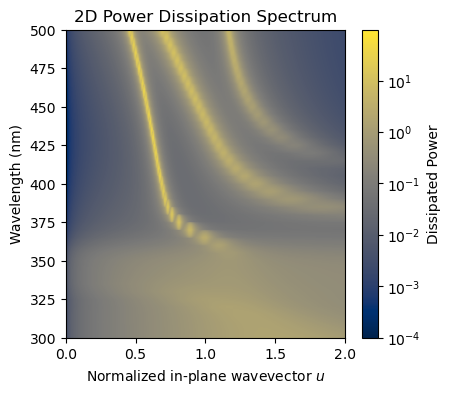

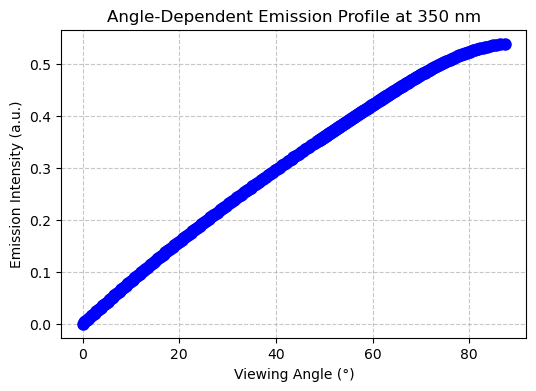

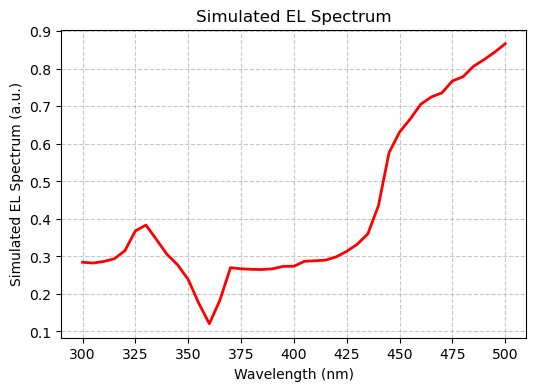

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from oledpy.dipole_emission import ThinFilmArchitecture
import warnings
warnings.filterwarnings('ignore')

##############################################
# 1. 데이터 로드 및 전처리
##############################################

# PL 데이터 로드 (단일 헤더 구조)
pl_file_path = os.path.join("Reference Data", "tesu_lee_PL_value.xlsx")
df_pl = pd.read_excel(pl_file_path, sheet_name="Sheet1", header=0)
print("\n=== PL Data ===")
print(df_pl.head())
print("PL columns:", df_pl.columns.tolist())

# NK 데이터 로드 (단일 헤더 구조)
nk_file_path = os.path.join("Reference Data", "tesu_lee_nk_value.xlsx")
df_nk = pd.read_excel(nk_file_path, sheet_name="Sheet1", header=0)
print("\n=== NK Data ===")
print(df_nk.head())
print("NK columns:", df_nk.columns.tolist())

# 필수 NK 컬럼 검증 (예: QD_n, QD_k 반드시 존재)
required_columns = ["QD_n", "QD_k"]
for col in required_columns:
    if col not in df_nk.columns:
        raise KeyError(f"{col} 컬럼 누락")

# 만약 NK 데이터가 단일 행이라면 vac_wavelengths 길이에 맞게 복제 (필요시)
if df_nk.shape[0] == 1:
    vac_wavelengths = np.arange(300, 501, 5)
    for col in df_nk.columns:
        if col != "nm":
            df_nk[col] = np.full(len(vac_wavelengths), df_nk[col].iloc[0])
    df_nk["nm"] = vac_wavelengths

##############################################
# 2. 시뮬레이션 파라미터 및 PL 스펙트럼 보간
##############################################
vac_wavelengths = np.arange(300, 501, 5)  # 300~500 nm, 5 nm 간격

# Blue PL 스펙트럼 보간 (예: 'wavelength_blue'와 'abs_blue' 컬럼 사용)
pl_spectrum_blue = np.interp(vac_wavelengths, df_pl["wavelength_blue"], df_pl["abs_blue"])
print("\nInterpolated Blue PL spectrum:")
print(pl_spectrum_blue)

dipole_positions = [0.9]

##############################################
# 3. 레이어 구조 정의
##############################################
# NK 데이터에 있는 재료명과 일치하도록 설정:
# 예: Bottom electrode: Ag, HIL: MoO3, HTL: TCTA, EML: QD, ETL: ZnO, Top electrode: Ag
layers = [
    {'name': 'Ag',   'd': 100, 'coherent': True,  'doping': 1},
    {'name': 'MoO3', 'd': 10,  'coherent': True,  'doping': 1},
    {'name': 'TCTA', 'd': 35,  'coherent': True,  'doping': 1},
    {'name': 'QD',   'd': 25,  'coherent': True,  'doping': 1, 'active': True},
    {'name': 'ZnO',  'd': 40,  'coherent': True,  'doping': 1},  # ETL; 두께를 나중에 변화시킬 예정
    {'name': 'Ag',   'd': 15,  'coherent': True,  'doping': 1}
]
print("\n=== Layers ===")
for lyr in layers:
    print(lyr)

##############################################
# 4. 기본 ThinFilmArchitecture 객체 생성 (기본 구조 설정)
##############################################
arch = ThinFilmArchitecture(
    layer_dict_list=layers,
    dipole_positions=dipole_positions,
    tau=1e-6,
    PLQY=0.95,
    vac_wavelengths=vac_wavelengths,
    pl_spectrum=pl_spectrum_blue
)
arch.load_nk(df_nk=df_nk)
arch.set_active_layer(3)  # QD 레이어 (인덱스 3) 활성층 지정
arch.run_attribute_checks()
print("\nThinFilmArchitecture set up complete!\n")

##############################################
# 5. Power Dissipation Spectrum 계산 및 2D 플롯 (기본 구조)
##############################################
# u (정규화된 in-plane wavevector) 그리드 생성
custom_u = np.hstack((
    np.arange(0, 0.75, 0.005),
    np.arange(0.75, 1, 0.001),
    np.arange(1+0.001, 2, 0.002),
    np.arange(2, 10, 0.1)
))
arch.init_pds_variables(custom_u=custom_u)
arch.calc_r_and_t()
K_data = arch.calc_K()
# z 배열: shape (len(vac_wavelengths), len(u)) → (41, len(custom_u))
z = K_data['K_total'][0, :, :] * arch.u

lev_exp = np.arange(-4, np.ceil(np.log10(z.max())), 0.01)
levs = np.power(10, lev_exp)

fig, ax = plt.subplots(figsize=(4.5, 4))
cs = ax.contourf(arch.u, vac_wavelengths, z, levs, norm=colors.LogNorm(), cmap='cividis')
ticks = 10 ** np.arange(-4, np.ceil(np.log10(z.max())+1), 1)
cbar = plt.colorbar(cs, ticks=ticks)
cbar.set_label('Dissipated Power')
ax.set_xlabel('Normalized in-plane wavevector $u$')
ax.set_ylabel('Wavelength (nm)')
ax.set_xlim(0, 2)
plt.title('2D Power Dissipation Spectrum')
plt.savefig(os.path.join("Plots", "power_dissipation_2d.png"), dpi=300, bbox_inches='tight')
plt.show()

##############################################
# 6. 각도 종속 방출 프로파일 및 EL 스펙트럼 계산
##############################################
# 각도 종속 방출 프로파일 계산:
# u 그리드: arch.u (길이 = len(custom_u)), vac_wavelengths: 41
# z 배열 shape: (41, len(custom_u))
# 자유공간 영역 (u <= 1) 선택: 마스크를 두 번째 축에 적용 (열 인덱스)
mask = arch.u <= 1
u_free = arch.u[mask]
theta_rad = np.arcsin(u_free)
theta_deg = np.degrees(theta_rad)
z_free = z[:, mask]  # 이제 shape: (41, number of u_free)

# 특정 파장 (예: index 10, 약 350 nm)에서 각도 종속 프로파일
lambda_idx = 10
angular_profile = z_free[lambda_idx, :]  # 각 u_free에 해당하는 값

plt.figure(figsize=(6,4))
plt.plot(theta_deg, angular_profile, 'bo-', markersize=8)
plt.xlabel('Viewing Angle (°)')
plt.ylabel('Emission Intensity (a.u.)')
plt.title(f'Angle-Dependent Emission Profile at {vac_wavelengths[lambda_idx]} nm')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# EL 스펙트럼 계산: 자유공간 영역(u<=1)에서 z 값을 u축 적분하여 각 파장에서의 방출 강도 추정
EL_spectrum = np.trapz(z[:, mask], u_free, axis=1)
plt.figure(figsize=(6,4))
plt.plot(vac_wavelengths, EL_spectrum, 'r-', linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Simulated EL Spectrum (a.u.)')
plt.title('Simulated EL Spectrum')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

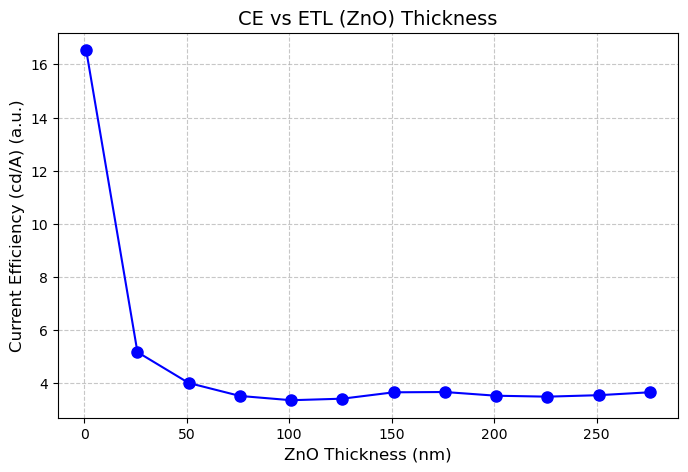

In [5]:
##############################################
# 7. ETL 두께 최적화 시뮬레이션 (CE vs. ZnO Thickness)
##############################################
def integrate_K_to_CE(K_data):
    # 단순 예시: K_total[0,:,:]의 적분 후 평균을 CE로 추정 (실제 모델에 맞게 수정)
    return np.trapz(K_data['K_total'][0, :, :], dx=0.01).mean()

# ZnO 두께를 1 nm부터 300 nm까지 25 nm 간격으로 설정
zno_thicknesses = np.arange(1, 301, 25)
ce_results = []
for d_zn in zno_thicknesses:
    layers[4]['d'] = d_zn  # ZnO (ETL) 두께 변경
    
    arch_etl = ThinFilmArchitecture(
        layer_dict_list=layers,
        dipole_positions=dipole_positions,
        tau=1e-6,
        PLQY=0.95,
        vac_wavelengths=vac_wavelengths,
        pl_spectrum=pl_spectrum_blue
    )
    arch_etl.load_nk(df_nk=df_nk)
    arch_etl.set_active_layer(3)  # 활성층 지정: QD (인덱스 3)
    arch_etl.run_attribute_checks()
    arch_etl.init_pds_variables(custom_u=custom_u)
    arch_etl.calc_r_and_t()
    K_etl = arch_etl.calc_K()
    
    CE = integrate_K_to_CE(K_etl)
    ce_results.append(CE)

plt.figure(figsize=(8,5))
plt.plot(zno_thicknesses, ce_results, 'bo-', markersize=8)
plt.xlabel('ZnO Thickness (nm)', fontsize=12)
plt.ylabel('Current Efficiency (cd/A) (a.u.)', fontsize=12)
plt.title('CE vs ETL (ZnO) Thickness', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:01<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

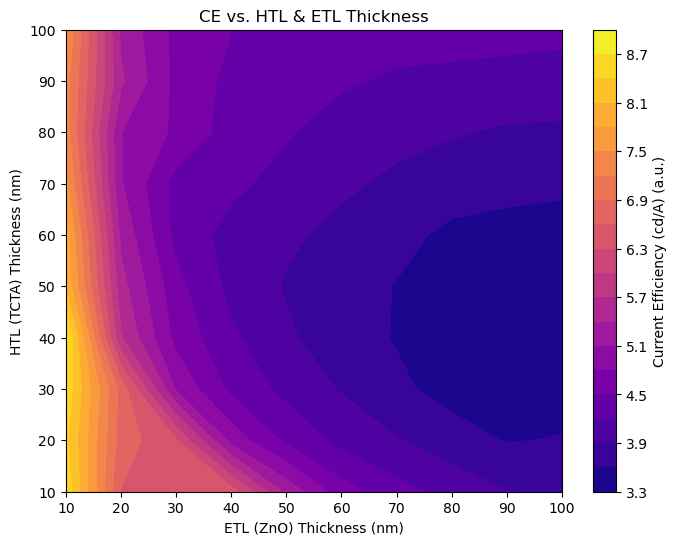

In [7]:
##############################################
# 7. HTL 및 ETL 두께 최적화 시뮬레이션 (CE vs. HTL & ZnO Thickness)
##############################################
# 가상의 integrate_K_to_CE 함수 (실제 물리 모델에 맞게 수정 필요)
def integrate_K_to_CE(K_data):
    # 단순 예시: K_total[0, :, :]를 적분 후 평균 내어 CE로 추정
    return np.trapz(K_data['K_total'][0, :, :], dx=0.01).mean()

# HTL (TCTA)와 ETL (ZnO) 두께를 각각 10nm부터 100nm까지 10nm 간격으로 변화시킴
HTL_values = np.arange(10, 101, 10)
ETL_values = np.arange(10, 101, 10)
CE_matrix = np.zeros((len(HTL_values), len(ETL_values)))

for i, ht in enumerate(HTL_values):
    layers[2]['d'] = ht  # HTL 두께 업데이트 (index 2: TCTA)
    for j, et in enumerate(ETL_values):
        layers[4]['d'] = et  # ETL 두께 업데이트 (index 4: ZnO)
        
        # 새로운 구조 객체 생성
        arch_opt = ThinFilmArchitecture(
            layer_dict_list=layers,
            dipole_positions=dipole_positions,
            tau=1e-6,
            PLQY=0.95,
            vac_wavelengths=vac_wavelengths,
            pl_spectrum=pl_spectrum_blue
        )
        arch_opt.load_nk(df_nk=df_nk)
        arch_opt.set_active_layer(3)  # 활성층: QD (인덱스 3)
        arch_opt.run_attribute_checks()
        arch_opt.init_pds_variables(custom_u=custom_u)
        arch_opt.calc_r_and_t()
        K_opt = arch_opt.calc_K()
        
        CE_matrix[i, j] = integrate_K_to_CE(K_opt)

plt.figure(figsize=(8,6))
X, Y = np.meshgrid(ETL_values, HTL_values)
cp = plt.contourf(X, Y, CE_matrix, 20, cmap='plasma')
plt.colorbar(cp, label='Current Efficiency (cd/A) (a.u.)')
plt.xlabel('ETL (ZnO) Thickness (nm)')
plt.ylabel('HTL (TCTA) Thickness (nm)')
plt.title('CE vs. HTL & ETL Thickness')
plt.show()

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

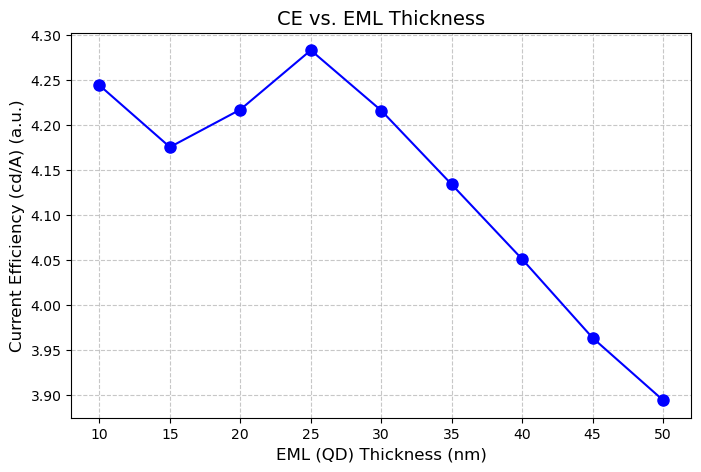

In [8]:
# 가상의 integrate_K_to_CE 함수 (실제 물리 모델에 맞게 수정 필요)
def integrate_K_to_CE(K_data):
    # 단순 예시: K_total[0,:,:]의 적분 후 평균을 효율(CE)로 근사
    return np.trapz(K_data['K_total'][0, :, :], dx=0.01).mean()

# EML 두께 (QD layer, 인덱스 3) 변화 범위: 10nm부터 50nm까지 5nm 간격
EML_thicknesses = np.arange(10, 51, 5)
efficiency_results = []

# 기존의 layers, dipole_positions, vac_wavelengths, pl_spectrum_blue, df_nk, custom_u 등은 이미 설정되어 있다고 가정
for d_eml in EML_thicknesses:
    layers[3]['d'] = d_eml  # EML 두께 변경 (인덱스 3: QD)
    
    # 새로운 구조 객체 생성
    arch_eml = ThinFilmArchitecture(
        layer_dict_list=layers,
        dipole_positions=dipole_positions,
        tau=1e-6,
        PLQY=0.95,
        vac_wavelengths=vac_wavelengths,
        pl_spectrum=pl_spectrum_blue
    )
    arch_eml.load_nk(df_nk=df_nk)
    arch_eml.set_active_layer(3)  # 활성층 지정: QD (인덱스 3)
    arch_eml.run_attribute_checks()
    arch_eml.init_pds_variables(custom_u=custom_u)
    arch_eml.calc_r_and_t()
    K_eml = arch_eml.calc_K()
    
    # 효율 추정 (예시)
    CE = integrate_K_to_CE(K_eml)
    efficiency_results.append(CE)

# EML 두께에 따른 효율(CE) 그래프 그리기
plt.figure(figsize=(8,5))
plt.plot(EML_thicknesses, efficiency_results, 'bo-', markersize=8)
plt.xlabel('EML (QD) Thickness (nm)', fontsize=12)
plt.ylabel('Current Efficiency (cd/A) (a.u.)', fontsize=12)
plt.title('CE vs. EML Thickness', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
##############################################
# 7. ETL 두께 최적화 시뮬레이션 (CE vs. ZnO Thickness)
##############################################
def integrate_K_to_CE(K_data):
    # 단순 예시: K_total[0,:,:]의 적분 후 평균을 CE로 추정 (실제 모델에 맞게 수정)
    return np.trapz(K_data['K_total'][0, :, :], dx=0.01).mean()

# ZnO 두께를 1 nm부터 300 nm까지 25 nm 간격으로 설정
zno_thicknesses = np.arange(1, 301, 25)
ce_results = []
for d_zn in zno_thicknesses:
    layers[4]['d'] = d_zn  # ZnO (ETL) 두께 변경
    
    arch_etl = ThinFilmArchitecture(
        layer_dict_list=layers,
        dipole_positions=dipole_positions,
        tau=1e-6,
        PLQY=0.95,
        vac_wavelengths=vac_wavelengths,
        pl_spectrum=pl_spectrum_blue
    )
    arch_etl.load_nk(df_nk=df_nk)
    arch_etl.set_active_layer(3)  # 활성층 지정: QD (인덱스 3)
    arch_etl.run_attribute_checks()
    arch_etl.init_pds_variables(custom_u=custom_u)
    arch_etl.calc_r_and_t()
    K_etl = arch_etl.calc_K()
    
    CE = integrate_K_to_CE(K_etl)
    ce_results.append(CE)

plt.figure(figsize=(8,5))
plt.plot(zno_thicknesses, ce_results, 'bo-', markersize=8)
plt.xlabel('ZnO Thickness (nm)', fontsize=12)
plt.ylabel('Current Efficiency (cd/A) (a.u.)', fontsize=12)
plt.title('CE vs ETL (ZnO) Thickness', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]